# Train a model to predict a color type

In [1]:
import warnings

warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [3]:
df = pd.read_csv('data/warm_cold_colors.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
r          136 non-null int64
g          136 non-null int64
b          136 non-null int64
is_warm    136 non-null int64
dtypes: int64(4)
memory usage: 4.3 KB


In [5]:
df[['is_warm', 'r']].groupby(['is_warm'])\
                    .count()\
                    .reset_index()

,is_warm,r
0,0,68
1,1,68


### Explorative Data Analysis - EDA

In [6]:
axes_combinations = [('r', 'g'), 
                     ('r', 'b'), 
                     ('g', 'b')]

color_scale = {'Cool': 'blue', 
               'Warm':'red'}

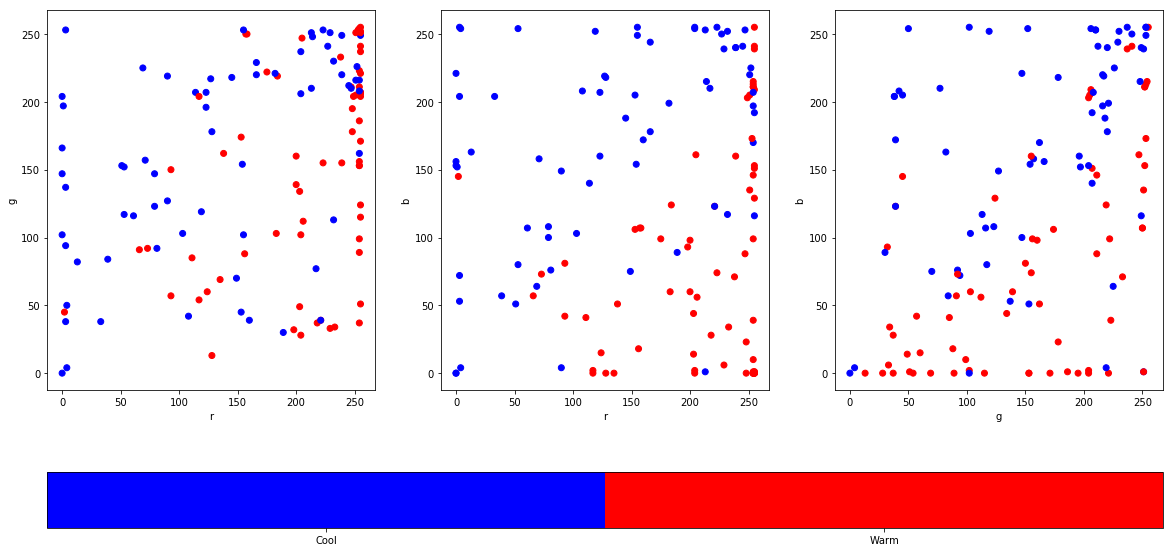

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    x, y = axes_combinations[i]
    
    im = ax.scatter(x=df[x], 
                    y=df[y], 
                    c=df['is_warm'], 
                    cmap=matplotlib.colors.ListedColormap(color_scale.values()))
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')    
cb.set_ticks([.25,.75])
cb.set_ticklabels(list(color_scale.keys()))

plt.show()

## Modelling

### Metrics

How close to reality a model's prediction can be; for a classificaiton problem, <a href="https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62" target="_blank">consufion matrix</a> is usually used.

In [8]:
%%html
<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" alt="Precisionrecall.svg" height="480" width="264">
<div style="text-align:center">
By <a href="//commons.wikimedia.org/wiki/User:Walber" title="User:Walber">Walber</a> - <span class="int-own-work" lang="en">Own work</span>, 
<a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=36926283">Link</a>
</div>

In order to reduce the flase negative and false positive rate, <em><strong>F1 score</strong></em> to be used as the model validation metric:

<div style="text-align:center">
    <font size="5">
        $F_{1} = \frac{2}{\frac{1}{Recall} + \frac{1}{Precision}}$
    </font>
<div style="text-align:center">    

<div style="text-align:center">
    <font size="5">
    $Recall = \frac{TP}{TP+FN}$
    </font>
</div>

describes what fraction of all true "positive" points did a model predict correctly

<div style="text-align:center">
    <font size="5">
        $Precision = \frac{TP}{TP+FP}$
    </font>
</div>

descibes what fraction of all predicted "Positive" points did a model predict correctly

Another widely <s>used</s> abused metric, <strong><em>accuracy</em></strong>:
<div style="text-align:center">
<font size="5">
    $Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$
</font>
</div>

In [9]:
def eval_metrics(y_true: np.array, 
                 y_pred: np.array) -> dict:
    """
    Function to calculate classification metrics
    
        Args:
            y_test: np.array, test subset
            y_predicitons: np.array prediciton on x_test
    
        Returs:

            dict with the keys:
                confusion_matrix - confusion matrix
                accuracy = (TP+TN)/(TP+TN+FP+FN)
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1_score = 2/(1/recall+1/precision)    
    """
    
    assert len(y_true) != 0, "Empty array, please check input"
    
    true_positives = np.where(y_true==1)[0]    
    TP = sum(y_pred[true_positives]==1)
    FN = sum(y_pred[true_positives]==0)
    
    true_negatives = np.where(y_true==0)[0]
    FP = sum(y_pred[true_negatives]==1)
    TN = sum(y_pred[true_negatives]==0)
    
    accuracy = (TP + TN) / len(y_true)
    
    recall = precision = f1_score = None
    
    if FN > 0 or TP > 0:
        recall = float(TP / (TP + FN))
        
    if FP > 0 or TP > 0:
        precision = float(TP / (TP + FP))

    if recall and precision:
        f1_score = 2/(1/recall+1/precision)    
        
    return {"confusion_matrix": {
                "TP": TP, "FP": FP, 
                "FN": FN, "TN": TN
            },
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score
           } 

### Baseline

#### As a baseline, we can set the condition:

```javascript
if r > g > b:
    color_type = 'Warm'
else:
    color_type = 'Cool'
```

In [10]:
class model_baseline:
    """
    Baseline model
    """
    def __init__(self):
        pass
    
    def _rule(self, row: pd.DataFrame) -> int:
        """
        Model rule
            Args:
                Row: pd.DataFrame row
            
            Return:
                int
        """
        
        if row['r'] > row['g'] > row['b']:
            return 1
        
        return 0
    
    def predict(self, X: pd.DataFrame) -> np.array:
        """
        Function to run a base line prediction 
            
            Args:
                X: input data
            
            Returns:
                array
        """
        
        return X.apply(lambda row: self._rule(row), axis=1)

In [11]:
# baseline model
model_base = model_baseline()

y_predict_baseline = model_base.predict(df[['r', 'g', 'b']])

In [12]:
# baseline model evaluation

eval_metrics(df['is_warm'], y_predict_baseline)

{'confusion_matrix': {'TP': 43, 'FP': 5, 'FN': 25, 'TN': 63},
 'accuracy': 0.7794117647058824,
 'recall': 0.6323529411764706,
 'precision': 0.8958333333333334,
 'f1_score': 0.7413793103448275}

So without any machine learning, we were managed to get the F1 score of <strong>74%</strong> :)

Let's assess out "model" using a random data point:

In [13]:
# test point -> a color of the "Cool" type/class 0

test_point = pd.DataFrame({'r': [8], 'g': [103], 'b': [203]})

In [14]:
model_base.predict(test_point).squeeze()

0

Let's dump the baseline model and deploy it as a POC

In [15]:
import pickle

def save_object(obj, filename):
    """
    Function to save/pickle python object

        Args:
            filename: str path to pickle file
    """

    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [16]:
save_object(model_base, 'model/model_baseline.sav')

#### We can improve our ML service by improving our model's accuracy

### Data preparesion

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [69]:
seed = 2019

In [70]:
df = df.sample(frac=1, random_state=seed)\
       .reset_index(drop=True)

In [133]:
scale = MinMaxScaler()

In [135]:
X = df.drop('is_warm', axis=1)

In [137]:
X_scaled = scale.fit_transform(X)

In [138]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, df['is_warm'], 
                                                    test_size=0.2, 
                                                    random_state=seed)

### Shallow DNN

Let's try to build a dense neural network using <a href="https://keras.io/" target="_blank">keras</a>

In [45]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K

In [174]:
def precision(y_true, y_pred):
    """
    Function to calculate precision, or positive predictive value (PPV)
    PPV = TP/(TP+FP)
    
        Args:
            y_true - real label values
            y_pred - prediciton for label values        
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    """
    Function to calculate recall, or sensitivity, or true positive rate
    TPR = TP/(TP+FN)
    
        Args:
            y_true - real label values
            y_pred - prediciton for label values        
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    """
    Function to F1 score
        F1 = 2/(1/recall + 1/precision)

        Args:
            y_true - real label values
            y_pred - prediciton for label values        
    """
    def fbeta_score(y_true, y_pred, beta=1):
        # Calculates the F score, the weighted harmonic mean of precision and recall.
        if beta < 0:
            raise ValueError('The lowest choosable beta is zero (only precision).')
        # If there are no true positives, fix the F score at 0 like sklearn.
        if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
            return 0
        p = precision(y_true, y_pred)
        r = recall(y_true, y_pred)
        bb = beta ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

class callback(tf.keras.callbacks.Callback):
    
    def __init__(self, 
                 metric: str = 'acc', 
                 theshold: float = .6,
                 val: bool = False):
        """
        Calback to early stopping
        
            Args:
                mertic: str metric to monitor
                threshold: float threshold metric value
                val: bool shall validation metric be included
        """
        self.metric = metric
        self.theshold = theshold
        self.val = val
        
    def on_epoch_end(self, epoch, logs={}):
        
        if self.val:
            metric_val = f"val_{self.metric_val}"
            try:
                if(logs.get(self.metric) > self.theshold and 
                   logs.get(metric_val) > self.theshold):
                    self.model.stop_training = True
            except Exception as e:
                raise e

        if(logs.get(self.metric) > self.theshold):
            self.model.stop_training = True


In [187]:
callbacks = callback('f1_score', 0.85)

In [188]:
model_dnn = keras.models.Sequential([
    keras.layers.Dense(3, activation=keras.activations.relu, input_shape=[3]),
    keras.layers.Dense(5, activation=keras.activations.relu),
    keras.layers.Dense(2, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])

In [189]:
model_dnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss=keras.losses.binary_crossentropy, 
                  metrics=[f1_score])

In [190]:
model_dnn.fit(x_train, y_train, 
              batch_size=8, 
              epochs=1000, 
              validation_data=(x_test,y_test), 
              callbacks=[callbacks])

Train on 108 samples, validate on 28 samples
Epoch 1/1000
108/108 [==============================] - 0s 3ms/sample - loss: 0.7056 - f1_score: 0.5479 - val_loss: 0.6996 - val_f1_score: 0.4475
Epoch 2/1000
108/108 [==============================] - 0s 393us/sample - loss: 0.7025 - f1_score: 0.3507 - val_loss: 0.6970 - val_f1_score: 0.3250
Epoch 3/1000
108/108 [==============================] - 0s 509us/sample - loss: 0.6966 - f1_score: 0.1049 - val_loss: 0.6937 - val_f1_score: 0.0000e+00
Epoch 4/1000
108/108 [==============================] - 0s 514us/sample - loss: 0.6934 - f1_score: 0.0000e+00 - val_loss: 0.6927 - val_f1_score: 0.0000e+00
Epoch 5/1000
108/108 [==============================] - 0s 474us/sample - loss: 0.6930 - f1_score: 0.0000e+00 - val_loss: 0.6926 - val_f1_score: 0.0000e+00
Epoch 6/1000
108/108 [==============================] - 0s 517us/sample - loss: 0.6929 - f1_score: 0.0000e+00 - val_loss: 0.6924 - val_f1_score: 0.0000e+00
Epoch 7/1000
108/108 [===================